# Example 4: Cross Channel Correlation Map

In this example we demonstrate the cross channel correlation map calculation. This image will be useful for later death signal identification.

In [59]:
import dask_image.imread
import matplotlib.pyplot as plt
%matplotlib inline

from cyto.preprocessing.cross_channel_correlation import *
import os

from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter

## Load Data

Immunofluorescence staining setup in our cytotoxicity dataset

| Channels      | Stain         |
| ------------- | ------------- |
| Cancer Cells      | GFP |
| Death Signal      | PI      |
| T Cells | DRCT      |

In [60]:
GFP_FILE_PATTERN = "/mnt/Data/UTSE/2023_11_15_1G4PrimCD8_CTFR_100nm_ICAM_5ug_Nyeso1_HCT116_framerate10sec_flow_0p1mlperh_withIL2_analysis/Full_size/register_denoising_gamma/ch0/*.tif"
PI_FILE_PATTERN = "/mnt/Data/UTSE/2023_11_15_1G4PrimCD8_CTFR_100nm_ICAM_5ug_Nyeso1_HCT116_framerate10sec_flow_0p1mlperh_withIL2_analysis/Full_size/register_denoising_gamma/ch1/*.tif"
DRCT_FILE_PATTERN = "/mnt/Data/UTSE/2023_11_15_1G4PrimCD8_CTFR_100nm_ICAM_5ug_Nyeso1_HCT116_framerate10sec_flow_0p1mlperh_withIL2_analysis/Full_size/register_denoising_gamma/ch2/*.tif"

For lazy loading of time splitted TIFF images, Dask Image reader is recommended

In [61]:
GFP_image = dask_image.imread.imread(GFP_FILE_PATTERN)
PI_image = dask_image.imread.imread(PI_FILE_PATTERN)
DRCT_image = dask_image.imread.imread(DRCT_FILE_PATTERN)

GFP_image

dask.array<_map_read_frame, shape=(8690, 2400, 2400), dtype=uint16, chunksize=(1, 2400, 2400), chunktype=numpy.ndarray>

## Visualize the loaded image data

Text(0.5, 1.0, 'DRCT')

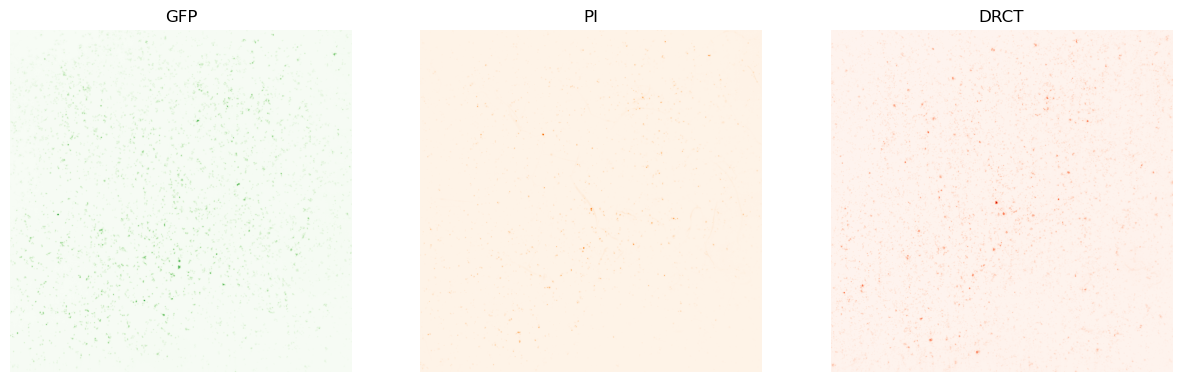

In [62]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

axs[0].imshow(GFP_image[0,:,:].T,cmap="Greens")
axs[0].set_axis_off()
axs[0].set_title("GFP")

axs[1].imshow(PI_image[0,:,:].T,cmap="Oranges")
axs[1].set_axis_off()
axs[1].set_title("PI")

axs[2].imshow(DRCT_image[0,:,:].T,cmap="Reds")
axs[2].set_axis_off()
axs[2].set_title("DRCT")

## Cross Pixel Correlation

In [63]:
FRAMES_start = 8000
FRAMES_end = 8691
FRAMES = 2000

### Cancer cells
GFP vs PI correlation

In [64]:
images = {}
images[0] = GFP_image.T[:,:,FRAMES_start:FRAMES_end].persist()
images[1] = PI_image.T[:,:,FRAMES_start:FRAMES_end].persist()

ccc = CrossChannelCorrelation(mode="SLICE", method="MEDIAN")
res = ccc({"images": images})

cancer_corr_map = res["output"]

100%|██████████| 690/690 [02:11<00:00,  5.24it/s]


### T cells
PI vs DRCT correlation

In [65]:
images = {}
images[0] = PI_image.T[:,:,FRAMES_start:FRAMES_end].persist()
images[1] = DRCT_image.T[:,:,FRAMES_start:FRAMES_end].persist()

ccc = CrossChannelCorrelation(mode="SLICE", method="MEDIAN")
res = ccc({"images": images})

tcell_corr_map = res["output"]


100%|██████████| 690/690 [02:07<00:00,  5.40it/s]


### Correlation map

Text(0.5, 1.0, 'T Cell Death Correlation Map')

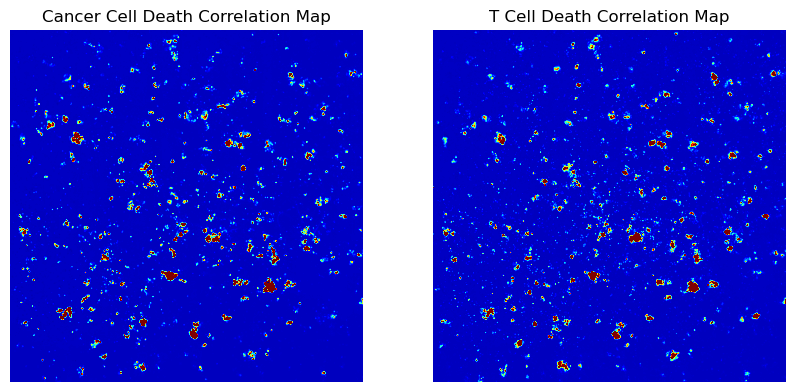

In [66]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].imshow(cancer_corr_map[:,:,0],cmap="jet",vmin=32768-128,vmax=32768+2048)
axs[0].set_axis_off()
axs[0].set_title("Cancer Cell Death Correlation Map")

axs[1].imshow(tcell_corr_map[:,:,0],cmap="jet",vmin=32768-128,vmax=32768+2048)
axs[1].set_axis_off()
axs[1].set_title("T Cell Death Correlation Map")

In [67]:
# store the result
output_dir =  "/mnt/Data/UTSE/2023_11_15_1G4PrimCD8_CTFR_100nm_ICAM_5ug_Nyeso1_HCT116_framerate10sec_flow_0p1mlperh_withIL2_analysis/Full_size/register_denoising_gamma_cc_5"
os.makedirs(output_dir,exist_ok=True)

for c in ["cancer","tcell"]:
    os.makedirs(os.path.join(output_dir,c),exist_ok=True)

for t in tqdm(range(FRAMES)):
    output_file = os.path.join(output_dir, "cancer","im{}.tif".format(str(t).zfill(5)))
    OmeTiffWriter.save(cancer_corr_map[:,:,t].T, output_file, dim_order="YX")

    output_file = os.path.join(output_dir, "tcell","im{}.tif".format(str(t).zfill(5)))
    OmeTiffWriter.save(tcell_corr_map[:,:,t].T, output_file, dim_order="YX")

 34%|███▍      | 690/2000 [01:16<02:25,  9.03it/s]


IndexError: index 690 is out of bounds for axis 2 with size 690